In [ ]:
!pip3 install anytree

In [1]:
from lean_euler import LeanEuler
import networkx as nx
from euler_input_visualization_nxpd import visualize_euler_input
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_query import PWEQuery
from PW_explorer.Custom_Visualization_Functions import euler_visualization_nxpd
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import itertools

In [2]:
import PW_explorer as pwe

In [3]:
Xs = []
ys = []

In [4]:
# CEN-NDC
cleantax_file = [
    '# Taxonomy-1: NSF BD Hubs http://www.nsf.gov/pubs/2015/nsf15562/nsf15562.htm',
    '# Taxonomy 2: http://www.nationaldiversitycouncil.org/wp-content/uploads/2011/12/us_regions.jpg',
    '#',
    'taxonomy CEN Census_Regions',
    '(USA Northeast Midwest South West)',
    'taxonomy NDC National_Diversity_Council',
    '(USA Midwest Northeast Southeast Southwest West)',
    'articulations CEN NDC',
    '[CEN.USA equals NDC.USA]',
    '[CEN.West includes NDC.West]',
    '[CEN.West disjoint NDC.Northeast]',
    '[CEN.South overlaps NDC.Southwest]',
    '[CEN.South includes NDC.Southeast]',
    '[CEN.Midwest equals NDC.Midwest]',
    '[CEN.Northeast is_included_in NDC.Northeast]',
    '']

In [28]:
cleantax_file = [
    'taxonomy CEN Census_Regions',
    '(USA Midwest South West Northeast)',
    'taxonomy TZ Time_Zone',
    '(USA Pacific Mountain Central Eastern)',
    'articulations CEN TZ',
    '[CEN.Midwest disjoint TZ.Pacific]',
    '[CEN.Midwest overlaps TZ.Eastern]',
    '[CEN.Midwest overlaps TZ.Mountain]',
    '[CEN.Northeast is_included_in TZ.Eastern]',
    '[CEN.South disjoint TZ.Pacific]',
    '[CEN.South overlaps TZ.Central]',
    '[CEN.South overlaps TZ.Eastern]',
    '[CEN.South overlaps TZ.Mountain]',
    '[CEN.USA equals TZ.USA]',
    '[CEN.West disjoint TZ.Central]',
    '[CEN.West disjoint TZ.Eastern]',
    '[CEN.West overlaps TZ.Mountain]',
    '']

In [52]:
 cleantax_file = [
    'taxonomy NDC National_Diversity_Council',
    '(USA Midwest Northeast Southeast Southwest West)',
    'taxonomy TZ Time_Zone',
    '(USA Pacific Mountain Central Eastern)',
    'articulations NDC TZ',
    '[NDC.Midwest overlaps TZ.Eastern]',
    '[NDC.Midwest overlaps TZ.Mountain]',
    '[NDC.USA equals TZ.USA]',
    '[NDC.Southwest overlaps TZ.Mountain]',
    '[NDC.Southeast disjoint TZ.Mountain]',
    '[NDC.West disjoint TZ.Central]',
    '[NDC.Southeast overlaps TZ.Central]',
    '[NDC.Midwest overlaps TZ.Central]',
    '[NDC.Northeast is_included_in TZ.Eastern]',
    '[NDC.Southwest disjoint TZ.Eastern]',
    '[NDC.West includes TZ.Pacific]',
    '[NDC.West disjoint TZ.Eastern]',
    '']

In [53]:
gt_rel_data, tax_data = LeanEuler.parse_cleantax(cleantax_file)

In [54]:
gt_rel_data

,Node1,Relation,Node2
0,"""NDC_USA""",parent,"""NDC_Midwest"""
1,"""NDC_USA""",parent,"""NDC_Northeast"""
2,"""NDC_USA""",parent,"""NDC_Southeast"""
3,"""NDC_USA""",parent,"""NDC_Southwest"""
4,"""NDC_USA""",parent,"""NDC_West"""
5,"""TZ_USA""",parent,"""TZ_Pacific"""
6,"""TZ_USA""",parent,"""TZ_Mountain"""
7,"""TZ_USA""",parent,"""TZ_Central"""
8,"""TZ_USA""",parent,"""TZ_Eastern"""
9,"""NDC_Midwest""",o,"""TZ_Eastern"""


In [55]:
#tax_data

In [56]:
gt_rules = LeanEuler.gen_asp_rules(gt_rel_data, tax_data, encoding='mnpw')

In [57]:
print('\n'.join(gt_rules))

r(1..29).

% Region Meanings
in(X, M) :- r(M), concept(X, T, N), N1=N+1, bit(M, T, N1).
out(X, M) :- r(M), concept(X, T, N), N1=N+1, not bit(M, T, N1).
in(X, M) :- r(M), concept2(X, _), not out(X, M).
irs(M) :- in(X, M), out(X, M), r(M), concept2(X, _).

% Region Constraints
irs(X) :- ir(X, _).
vrs(X) :- vr(X, _).
vr(X, X) :- not irs(X), r(X).
ir(X, X) :- not vrs(X), r(X).
:- vrs(X), irs(X).

concept2(A, B) :- concept(A,B,_).

% Taxonomy Description

%  Euler Bit
bit(M, 0, V) :- r(M), M1=M/1, V = M1 \ 6.

%  Euler Bit
bit(M, 1, V) :- r(M), M1=M/6, V = M1 \ 5.

concept2("NDC_USA", 0).
concept("NDC_Midwest", 0, 0).
concept("NDC_Northeast", 0, 1).
concept("NDC_Southeast", 0, 2).
concept("NDC_Southwest", 0, 3).
concept("NDC_West", 0, 4).
concept2("TZ_USA", 1).
concept("TZ_Pacific", 1, 0).
concept("TZ_Mountain", 1, 1).
concept("TZ_Central", 1, 2).
concept("TZ_Eastern", 1, 3).

% "NDC_Midwest" isa "NDC_USA"
ir(X, r2579) :- in("NDC_Midwest", X), out("NDC_USA", X).
:- #count {X : vrs(X), in("N

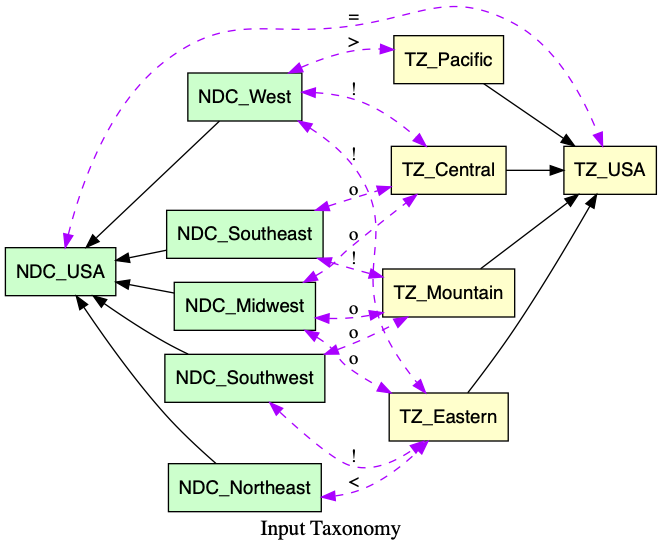

In [58]:
gt_G = visualize_euler_input(gt_rel_data, tax_data)
draw(gt_G)

In [59]:
gt_clingo_soln = run_clingo(clingo_rules=gt_rules)
print('\n'.join(gt_clingo_soln))

Answer: 1
u("NDC_Midwest") u("NDC_Northeast") u("NDC_Southeast") u("NDC_Southwest") u("NDC_West") u("TZ_Pacific") u("TZ_Mountain") u("TZ_Central") u("TZ_Eastern") u("NDC_USA") u("TZ_USA") bl("NDC_USA","NDC_Midwest") bl("NDC_USA","NDC_Northeast") bl("NDC_USA","NDC_Southeast") bl("NDC_USA","NDC_Southwest") bl("NDC_USA","NDC_West") bl("TZ_USA","TZ_Pacific") bl("TZ_USA","TZ_Mountain") bl("TZ_USA","TZ_Central") bl("TZ_USA","TZ_Eastern") pp("NDC_Midwest","NDC_USA") pp("NDC_Northeast","NDC_USA") pp("NDC_Southeast","NDC_USA") pp("NDC_Southwest","NDC_USA") pp("NDC_West","NDC_USA") pp("TZ_Pacific","TZ_USA") pp("TZ_Mountain","TZ_USA") pp("TZ_Central","TZ_USA") pp("TZ_Eastern","TZ_USA") rel("NDC_Midwest","TZ_Pacific","!") rel("NDC_Northeast","TZ_Pacific","!") rel("NDC_Northeast","TZ_Mountain","!") rel("NDC_Northeast","TZ_Central","!") rel("NDC_Southeast","TZ_Pacific","!") rel("NDC_Southeast","TZ_Mountain","!") rel("NDC_Southwest","TZ_Pacific","!") rel("NDC_Southwest","TZ_Eastern","!") rel("NDC_Wes

In [60]:
gt_dfs, gt_rels, gt_pws = load_worlds(clingo_output=gt_clingo_soln, preprocessed=False, reasoner='clingo')

Number of Models: 1


In [61]:
list(map(lambda x: x.__dict__, gt_rels))

[{'relation_name': 'u_1', 'arity': 1, 'r_id': 0},
 {'relation_name': 'bl_2', 'arity': 2, 'r_id': 1},
 {'relation_name': 'pp_2', 'arity': 2, 'r_id': 2},
 {'relation_name': 'rel_3', 'arity': 3, 'r_id': 3},
 {'relation_name': 'eq_2', 'arity': 2, 'r_id': 4},
 {'relation_name': 'po_2', 'arity': 2, 'r_id': 5},
 {'relation_name': 'dr_2', 'arity': 2, 'r_id': 6}]

In [62]:
gt_pws_vizs = euler_visualization_nxpd.visualize(dfs=gt_dfs, pws=gt_pws, relations=gt_rels, conn=None, project_name='ndc_tz', save_to_file=False)

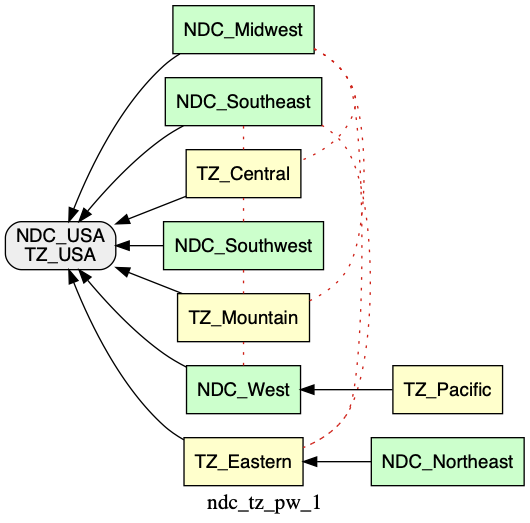

In [63]:
draw(gt_pws_vizs[0])

In [4]:
def dist_func(rels, dfs, pws, pw_id_1, pw_id_2):
#     return len(PWEQuery.unique_tuples(relations=rels, 
#                                       col_names=['x1','x2','x3'], 
#                                       dfs=dfs, do_print=False, 
#                                       expected_pws=len(pws), 
#                                       rl_id=pwe.pwe_helper.rel_id_from_rel_name(rel_name='rel_3', relations=rels), 
#                                       pws_to_consider=[pw_id_1, pw_id_2]))
    return len(PWEQuery.difference_both_ways(col_names=['x1','x2','x3'], 
                                             dfs=dfs, do_print=False, 
                                             pw_id_1=pw_id_1, pw_id_2=pw_id_2, 
                                             relations=rels, 
                                             rl_id=pwe.pwe_helper.rel_id_from_rel_name(rel_name='rel_3', relations=rels)))


In [5]:
from copy import deepcopy
def add_gt(gt_rels, gt_dfs, gt_pws, rels, dfs, pws):
    
    new_rels = deepcopy(rels)
    new_dfs = deepcopy(dfs)
    
    gt_pw = gt_pws[0]
    new_pw_id = len(pws)+1
    new_pw = pwe.pwe_helper.PossibleWorld(num_relations=len(rels), pw_id=new_pw_id)
    
    for rel in rels:
        gt_rel_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name=rel.relation_name, relations=gt_rels)
        if gt_rel_id is None:
            print("Didn't find the relation {} in Ground Truth. Skipping.".format(rel.relation_name))
            continue
        rel_id = rel.r_id
        new_pw.rls[rel_id] = deepcopy(gt_pw.rls[gt_rel_id])
        gt_rel_df = deepcopy(gt_dfs[gt_rel_id])
        gt_rel_df['pw'] = new_pw_id
        new_dfs[rel_id] = pd.concat([gt_rel_df, new_dfs[rel_id]], ignore_index=True)
    
    new_pws = pws + [new_pw]
    return new_rels, new_dfs, new_pws
        

In [6]:
# rl_set_to_rmv = (9,)
# k = list(range(len(gt_rel_data)))
# for rl in rl_set_to_rmv:
#     k.remove(rl)
# rel_data = gt_rel_data.iloc[k,:].copy(deep=False)
# rules = LeanEuler.gen_asp_rules(rel_data, tax_data, encoding='mnpw')
# clingo_soln = run_clingo(clingo_rules=rules)
# dfs, rels, pws = load_worlds(clingo_output=clingo_soln, preprocessed=False, reasoner='clingo')

In [7]:
# merged_rels, merged_dfs, merged_pws = add_gt(gt_rels, gt_dfs, gt_pws, rels, dfs, pws)

In [8]:
# distances = np.array([dist_func(merged_rels, merged_dfs, merged_pws, i, len(merged_pws)) for i in range(1, len(merged_pws))])

In [9]:
# distances

In [10]:
# distances = distances - np.min(distances)
# distances = distances / np.max(distances)
# distances = 1 - distances

In [11]:
# distances

In [12]:
def build_dataset_helper(gt_rels, gt_dfs, gt_pws, rels, dfs, pws, dist_func):
    
    merged_rels, merged_dfs, merged_pws = add_gt(gt_rels, gt_dfs, gt_pws, rels, dfs, pws)
    distances = np.array([dist_func(merged_rels, merged_dfs, merged_pws, i, len(merged_pws)) for i in range(1, len(merged_pws))])
    
    X = np.zeros((len(merged_pws)-1, len(merged_rels)))
    y = distances
    for rel in ['u_1', 'bl_2', 'pp_2', 'rel_3', 'eq_2', 'po_2', 'dr_2']:
        rel_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name=rel, relations=merged_rels)
        rel_df = merged_dfs[rel_id]
        for pw_id in range(len(merged_pws)-1):
            X[pw_id, rel_id] = len(rel_df[rel_df['pw'] == (pw_id+1)])
    return X, y



def build_dataset(gt_dfs, gt_pws, gt_rels, gt_rel_data, tax_data, rels_to_rmv, dist_func):
    
    Xs = []
    ys = []
    
    for rl_set_to_rmv in rels_to_rmv:
        
        k = list(range(len(gt_rel_data)))
        for rl in rl_set_to_rmv:
            k.remove(rl)
        rel_data = gt_rel_data.iloc[k,:].copy(deep=False)
        rules = LeanEuler.gen_asp_rules(rel_data, tax_data, encoding='mnpw')
        clingo_soln = run_clingo(clingo_rules=rules)
        dfs, rels, pws = load_worlds(clingo_output=clingo_soln, preprocessed=False, reasoner='clingo')
        
        curr_X, curr_y = build_dataset_helper(gt_rels, gt_dfs, gt_pws, rels, dfs, pws, dist_func)
        Xs.append(curr_X)
        ys.append(curr_y)

    
    X = np.vstack(tuple(Xs))
    y = np.hstack(tuple(ys))
    y = y - np.min(y)
    y = y/np.max(y)
    y = 1 - y
    
    return X, y

In [74]:
articulation_sets_to_rmv = list(itertools.combinations(range(9, len(gt_rel_data)), r=1)) + list(itertools.combinations(range(9, len(gt_rel_data)), r=2))
articulation_sets_to_rmv

[(9,),
 (10,),
 (11,),
 (12,),
 (13,),
 (14,),
 (15,),
 (16,),
 (17,),
 (18,),
 (19,),
 (20,),
 (9, 10),
 (9, 11),
 (9, 12),
 (9, 13),
 (9, 14),
 (9, 15),
 (9, 16),
 (9, 17),
 (9, 18),
 (9, 19),
 (9, 20),
 (10, 11),
 (10, 12),
 (10, 13),
 (10, 14),
 (10, 15),
 (10, 16),
 (10, 17),
 (10, 18),
 (10, 19),
 (10, 20),
 (11, 12),
 (11, 13),
 (11, 14),
 (11, 15),
 (11, 16),
 (11, 17),
 (11, 18),
 (11, 19),
 (11, 20),
 (12, 13),
 (12, 14),
 (12, 15),
 (12, 16),
 (12, 17),
 (12, 18),
 (12, 19),
 (12, 20),
 (13, 14),
 (13, 15),
 (13, 16),
 (13, 17),
 (13, 18),
 (13, 19),
 (13, 20),
 (14, 15),
 (14, 16),
 (14, 17),
 (14, 18),
 (14, 19),
 (14, 20),
 (15, 16),
 (15, 17),
 (15, 18),
 (15, 19),
 (15, 20),
 (16, 17),
 (16, 18),
 (16, 19),
 (16, 20),
 (17, 18),
 (17, 19),
 (17, 20),
 (18, 19),
 (18, 20),
 (19, 20)]

In [75]:
X_, y_ = build_dataset(gt_dfs, gt_pws, gt_rels, gt_rel_data, tax_data, articulation_sets_to_rmv, dist_func)

Number of Models: 2
Number of Models: 2
Number of Models: 432
Number of Models: 3
Number of Models: 3
Number of Models: 3
Number of Models: 3
Number of Models: 2
Number of Models: 7
Number of Models: 3
Number of Models: 53
Number of Models: 3
Number of Models: 3
Number of Models: 792
Number of Models: 6
Number of Models: 5
Number of Models: 6
Number of Models: 5
Number of Models: 3
Number of Models: 14
Number of Models: 6
Number of Models: 88
Number of Models: 6
Number of Models: 792
Number of Models: 6
Number of Models: 6
Number of Models: 5
Number of Models: 6
Number of Models: 3
Number of Models: 14
Number of Models: 6
Number of Models: 88
Number of Models: 5
Number of Models: 936
Number of Models: 1008
Number of Models: 1008
Number of Models: 936
Number of Models: 792
Number of Models: 5976
Number of Models: 1008
Number of Models: 21520
Number of Models: 1008
Number of Models: 9
Number of Models: 8
Number of Models: 8
Number of Models: 5
Number of Models: 21
Number of Models: 7
Num

In [76]:
Xs.append(X_)
ys.append(y_)

In [13]:
from copy import deepcopy

In [77]:
X = np.vstack(tuple(Xs))
y = np.hstack(tuple(ys))

In [5]:
len(y)

61133

In [14]:
import pickle as pkl
# with open('cen_ndc_tz_X.pkl', 'wb') as f:
#     pkl.dump(X, f)
# with open('cen_ndc_tz_y.pkl', 'wb') as f:
#     pkl.dump(y, f)
with open('cen_ndc_tz_X.pkl', 'rb') as f:
    X = pkl.load(f)
with open('cen_ndc_tz_y.pkl', 'rb') as f:
    y = pkl.load(f)

In [16]:
len(y)

61133

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [18]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True).fit(X_train, y_train)

/Users/sahil1105/PW-explorer/.env/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [19]:
reg.coef_

array([ 8.23759166e+10, -6.56054953e+10,  7.03308326e+09, -1.17937842e+10,
        7.03308326e+09,  7.03308326e+09,  7.03308326e+09])

In [20]:
reg.intercept_

-236162346976.03787

In [21]:
reg.score(X_train, y_train)

0.5537492456005795

In [22]:
reg.score(X_test, y_test)

0.554834930257982

In [63]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.0001, normalize=False, fit_intercept=True, solver='saga').fit(X_train, y_train)

In [64]:
ridge_reg.coef_

array([-0.00261249, -0.00261249,  0.03573285, -0.01306243, -0.01885601,
       -0.00666062, -0.02589113])

In [65]:
ridge_reg.intercept_

0.674431607587038

In [66]:
ridge_reg.score(X_train, y_train)

0.5537585409486274

In [67]:
ridge_reg.score(X_test, y_test)

0.5547397557019864

In [68]:
from sklearn.svm import SVR, SVC
clf = SVR(kernel='rbf', gamma='scale', C=0.05, epsilon=0.2)
#clf = SVC()
clf.fit(X_train, y_train)

SVR(C=0.05, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [69]:
clf.coef_

AttributeError: coef_ is only available when using a linear kernel

In [70]:
clf.intercept_

array([0.48638513])

In [71]:
clf.score(X_train, y_train)

0.5812437915686499

In [72]:
clf.score(X_test, y_test)

0.5854669722377279

In [73]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=0, max_depth=20)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [74]:
regressor.score(X_train, y_train)

0.6517072379846991

In [75]:
regressor.score(X_test, y_test)

0.6480486988695161

In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [77]:
pca.components_

array([[ 0.0246582 ,  0.0246582 ,  0.44489951,  0.123291  , -0.72643662,
        -0.07310081,  0.50258712],
       [-0.03183703, -0.03183703, -0.06021716, -0.15918517,  0.30213387,
        -0.84257003,  0.40963112],
       [-0.15428398, -0.15428398, -0.39801559, -0.77141988, -0.43880737,
        -0.00990024, -0.07898066],
       [ 0.0485037 ,  0.0485037 , -0.67269749,  0.2425185 ,  0.03087159,
         0.31166328,  0.62118483]])

In [78]:
X_train_pca = pca.transform(X_train)

In [79]:
X_test_pca = pca.transform(X_test)

In [80]:
rreg_pca = Ridge(alpha=0.000001, normalize=False, fit_intercept=True, solver='saga').fit(X_train_pca, y_train)

In [81]:
rreg_pca.score(X_train_pca, y_train)

0.5537581511549917

In [82]:
rreg_pca.score(X_test_pca, y_test)

0.5547499578287487

In [83]:
['u_1', 'bl_2', 'pp_2', 'rel_3', 'eq_2', 'po_2', 'dr_2']

['u_1', 'bl_2', 'pp_2', 'rel_3', 'eq_2', 'po_2', 'dr_2']

In [84]:
from sklearn.neural_network import MLPRegressor

In [100]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(10, 15, 20, 15, 10), activation='relu', solver='adam', alpha=0.01, 
                       learning_rate='adaptive', early_stopping=True, validation_fraction=0.1).fit(X_train, y_train)

In [101]:
mlp_reg.score(X_train, y_train)

0.6220052518401988

In [102]:
mlp_reg.score(X_test, y_test)

0.6211102575207686